# Model Explainability for Credit Risk Prediction

## Objective
The objective of this notebook is to explain model predictions using SHAP
(SHapley Additive exPlanations).

Explainability is critical in credit risk systems because:
- Regulatory compliance requires transparency
- Business teams must understand decisions
- Applicants may request explanations for rejection

This notebook focuses on both global and individual-level explanations.


In [3]:
import numpy as np
import pandas as pd

import shap
import joblib

import matplotlib.pyplot as plt

C:\Users\Dell\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Model and Data

We load the trained model, scaler, and feature list
saved during model training.


In [4]:
model = joblib.load("../models/credit_risk_model.pkl")
scaler = joblib.load("../models/scaler.pkl")
feature_columns = joblib.load("../models/feature_columns.pkl")

train_df = pd.read_csv("../data/processed/train_fe.csv")


## Prepare Data for Explainability

SHAP requires the same feature transformations used during training.
We recreate the training feature matrix.


In [5]:
X = train_df.drop(columns=["TARGET"])
y = train_df["TARGET"]

X = pd.get_dummies(X, drop_first=True)
X = X[feature_columns]

X_scaled = scaler.transform(X)


## Initialize SHAP Explainer

We use the SHAP LinearExplainer because the final model
is a Logistic Regression classifier.


In [6]:
explainer = shap.LinearExplainer(model, X_scaled)
shap_values = explainer.shap_values(X_scaled)


## Global Feature Importance

Global explanations help understand which features
contribute most to loan default risk across the population.


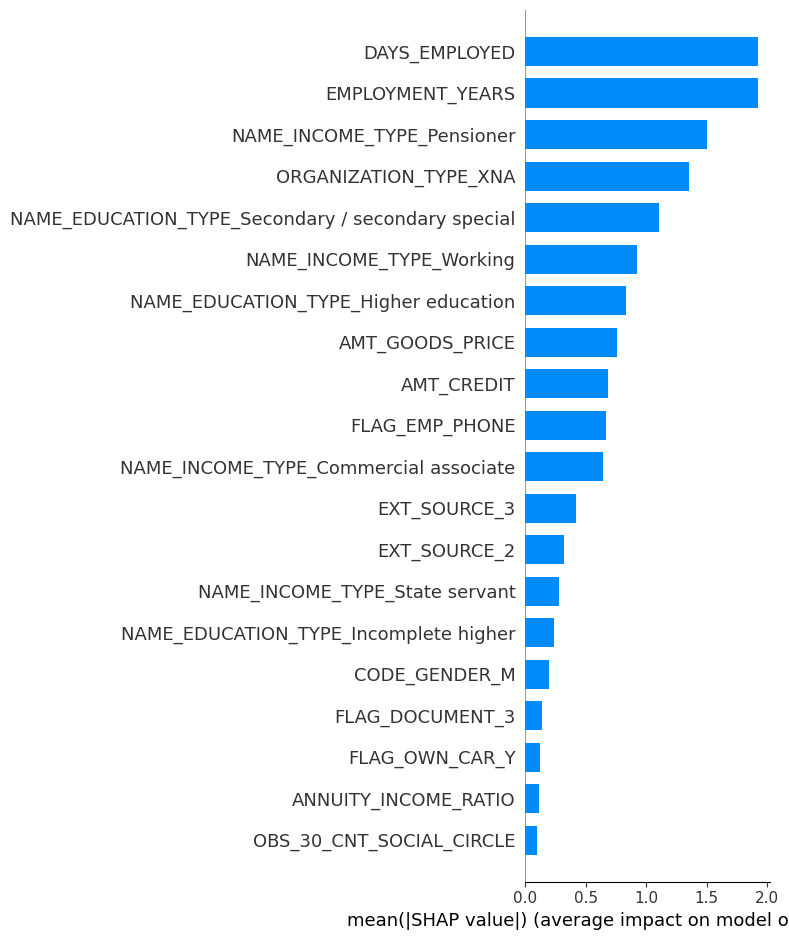

In [7]:
shap.summary_plot(shap_values, X, plot_type="bar")


## Feature Impact Analysis

This plot shows how feature values impact model predictions,
including direction and magnitude of influence.


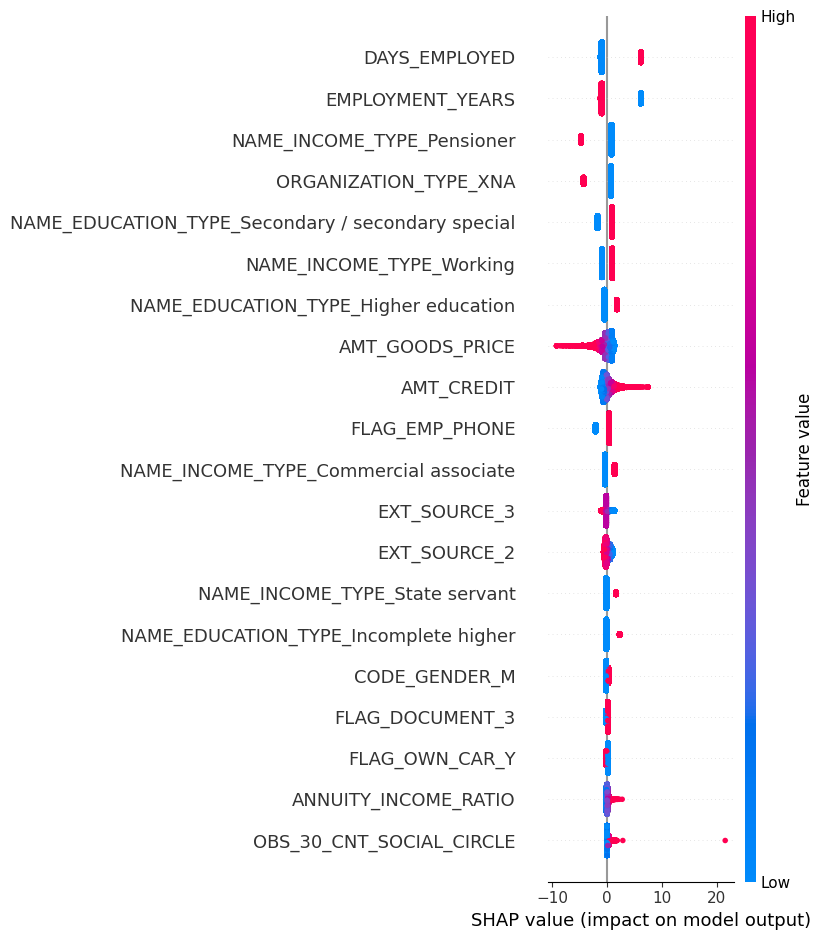

In [9]:
shap.summary_plot(shap_values, X)


## Individual Prediction Explanation

In real credit systems, it is critical to explain
why a specific applicant was approved or rejected.


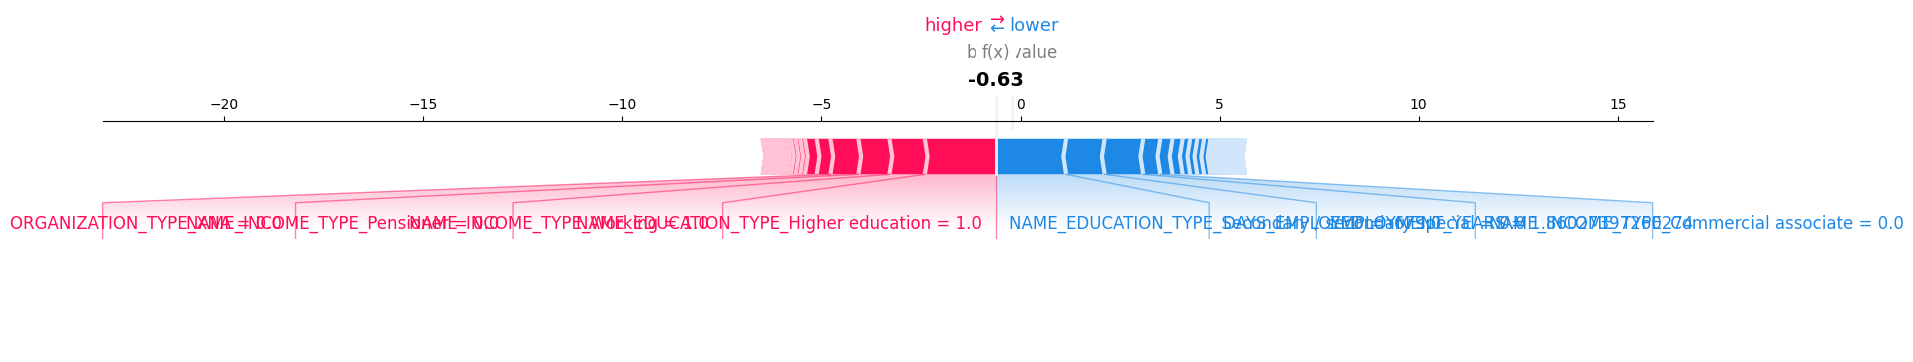

In [10]:
idx = 10  # sample applicant index

shap.force_plot(
    explainer.expected_value,
    shap_values[idx],
    X.iloc[idx],
    matplotlib=True
)


## Decision-Level Explanation

For rejected applications, we extract the top contributing factors.
This aligns with regulatory and business requirements.


In [11]:
def get_top_reasons(shap_vals, feature_names, top_n=3):
    feature_impact = pd.Series(shap_vals, index=feature_names)
    return feature_impact.sort_values(key=abs, ascending=False).head(top_n)

top_reasons = get_top_reasons(shap_values[idx], X.columns)
top_reasons


NAME_EDUCATION_TYPE_Higher education                 1.775520
NAME_EDUCATION_TYPE_Secondary / secondary special   -1.771676
DAYS_EMPLOYED                                       -0.968340
dtype: float64

## Fairness and Ethical Considerations

Credit risk models may unintentionally introduce bias.
We must ensure decisions are fair and responsible.

Considerations:
- Performance across income groups
- Sensitivity to employment status
- Exclusion of protected attributes

This model is intended to assist human decision-making,
not replace it entirely.


## Model Limitations

- Trained on historical data and may not generalize to future economic shifts
- Does not account for sudden income changes
- Requires regular monitoring and retraining
- Predictions should not be used as the sole decision factor


## Summary of Step 4

In this notebook, we:
- Applied SHAP for model explainability
- Analyzed global feature importance
- Explained individual predictions
- Extracted top decision-driving factors
- Discussed fairness, ethics, and limitations

The model is now transparent, interpretable, and suitable
for real-world decision support.
